Author: Pascal, pascal@bayesimpact.org

Date: 2018-12-18

# ROME update from v335 to v337

In December 2018 a new version of the ROME was released. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v335. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas as pd

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '335'
NEW_VERSION = '337'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
0 deleted files


So we have the same set of files in both versions: good start.

Now let's set up a dataset that, for each table, links both the old and the new file together.

In [3]:
# Load all ROME datasets for the two versions we compare.
VersionedDataset = collections.namedtuple('VersionedDataset', ['basename', 'old', 'new'])
rome_data = [VersionedDataset(
        basename=path.basename(f),
        old=pd.read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=pd.read_csv(f))
    for f in sorted(new_version_files)]

def find_rome_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_{}_v{}_utf8.csv'.format(partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [d.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in rome_data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

All files have the same columns as before: still good.

Now let's see for each file if there are more or less rows.

In [5]:
same_row_count_files = 0
for dataset in rome_data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d}/{:d} values added in {}'.format(
            diff, len(dataset.new.index), dataset.basename))
    elif diff < 0:
        print('{:d}/{:d} values removed in {}'.format(
            -diff, len(dataset.old.index), dataset.basename))
    else:
        same_row_count_files += 1
print('{:d}/{:d} files with the same number of rows'.format(
    same_row_count_files, len(rome_data)))

280/31099 values added in unix_coherence_item_v337_utf8.csv
17/11709 values added in unix_cr_gd_dp_appellations_v337_utf8.csv
9/2001 values added in unix_item_arborescence_v337_utf8.csv
159/13515 values added in unix_item_v337_utf8.csv
297/42684 values added in unix_liens_rome_referentiels_v337_utf8.csv
4/7410 values added in unix_referentiel_activite_riasec_v337_utf8.csv
174/9142 values removed in unix_referentiel_activite_v337_utf8.csv
17/11053 values added in unix_referentiel_appellation_v337_utf8.csv
76/4955 values removed in unix_referentiel_competence_v337_utf8.csv
2/5042 values added in unix_texte_v337_utf8.csv
11/21 files with the same number of rows


There are some minor changes in many files, but based on my knowledge of ROME, none from the main files.

The most interesting ones are in referentiel_appellation, item, and liens_rome_referentiels, so let's see more precisely.

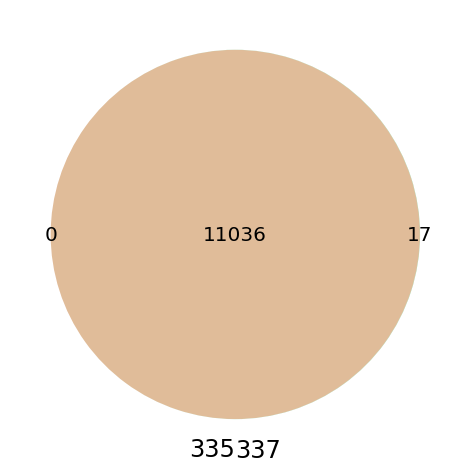

In [6]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')

new_jobs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
obsolete_jobs = set(jobs.old.code_ogr) - set(jobs.new.code_ogr)
stable_jobs = set(jobs.new.code_ogr) & set(jobs.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_jobs), len(new_jobs), len(stable_jobs)), (OLD_VERSION, NEW_VERSION));

Alright, so the only change seems to be 17 new jobs added. Let's take a look (only showing interesting fields):

In [7]:
pd.options.display.max_colwidth = 2000
jobs.new[jobs.new.code_ogr.isin(new_jobs)][['code_ogr', 'libelle_appellation_long', 'code_rome']]

,code_ogr,libelle_appellation_long,code_rome
3903,140943,Motion designer multimédia,E1205
3904,140944,Chef de chantier génie climatique,F1202
3905,140945,Facilitateur / Facilitatrice de FabLab - laboratoire de fabrication numérique,G1202
3906,140946,Technicien / Technicienne ERD en acoustique,H1210
3907,140947,Technicien / Technicienne en mesures acoustiques et contrôle du bruit,H1503
3908,140948,Accompagnant éducatif et social / Accompagnante éducative et sociale en structure collective,K1301
3909,140949,Accompagnant éducatif et social / Accompagnante éducative et sociale à domicile,K1302
3911,140950,Accompagnant éducatif et social / Accompagnante éducative et sociale en milieu scolaire,K2104
3912,140951,Motion designer - films d''animation,L1510
3913,140952,Développeur / Développeuse de logiciel de simulation optique et réalité virtuelle,M1805


They mostly seem to be new jobs: Business Developer, VR-related jobs, global climate jobs.

OK, let's check at the changes in items:

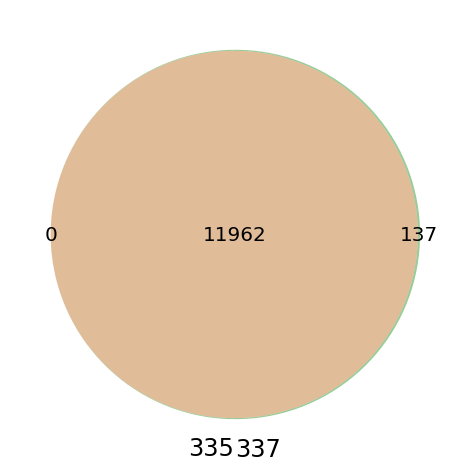

In [8]:
items = find_rome_dataset_by_name(rome_data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION));

As anticipated it is a very minor change (hard to see it visually): there are no obsolete items but new ones have been created. Let's have a look at them.

In [9]:
items.new[items.new.code_ogr.isin(new_items)].head()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
5934,115802,"Mettre en place des outils d''aide à la surveillance, à la sécurité et à l''exploitation des équipements informatiques",2,9,NaN,NaN,NaN
5935,115817,Contrôler la gestion de la paie,2,9,NaN,NaN,NaN
5951,115911,Responsabilité Sociétale des Entreprises (RSE),1,10,NaN,NaN,NaN
6074,116538,Techniques de réglage de lignes de conditionnement,1,10,NaN,NaN,NaN
6118,116639,Pharmacologie,1,7,NaN,NaN,NaN


The new ones seem legit to me.

The changes in `liens_rome_referentiels` include changes for those items, so let's only check the changes not related to those.

In [10]:
links = find_rome_dataset_by_name(rome_data, 'liens_rome_referentiels')
old_links_on_stable_items = links.old[links.old.code_ogr.isin(stable_items)]
new_links_on_stable_items = links.new[links.new.code_ogr.isin(stable_items)]

old = old_links_on_stable_items[['code_rome', 'code_ogr']]
new = new_links_on_stable_items[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added      33
removed     2
Name: _diff, dtype: int64

So in addition to the added and removed items, there are few fixes. Let's have a look at them:

In [11]:
job_group_names = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome').new.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
display(links_merged[links_merged._diff == 'removed'].dropna().head(5))
links_merged[links_merged._diff == 'added'].dropna().head(5)


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
15701,J1502,118117,left_only,removed,Coordination de services médicaux ou paramédicaux,Produits de puériculture
29277,A1503,122370,left_only,removed,Toilettage des animaux,Réaliser une Publicité sur le Lieu de Vente (PLV)


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
30819,D1205,101175,right_only,added,Nettoyage d''articles textiles ou cuirs,Techniques de repassage
30820,A1203,101869,right_only,added,Aménagement et entretien des espaces verts,Réglementation phytosanitaire
30821,G1101,104283,right_only,added,Accueil touristique,Environnement culturel et touristique
30822,G1102,104283,right_only,added,Promotion du tourisme local,Environnement culturel et touristique
30823,G1201,104283,right_only,added,"Accompagnement de voyages, d''activités culturelles ou sportives",Environnement culturel et touristique


Those fixes make sense (not sure why they were not done before, but let's not complain: it is fixed now).

That's all the changes we wanted to check (no change in `referentiel_code_rome`).

# Conclusion

The new version of ROME, v337, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/files/live/sites/peorg/files/documents/Statistiques-et-analyses/Open-data/ROME/ROME_AppropriationThematique.pdf). The transition should be transparent with a very small advantage over the old version.